In [1]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import pandas as pd
%matplotlib inline

The raw data contains 2000 actions of two type advertisement A and B. Action 1 means click, otherwise no click. We wish to identify statistical significance of user's reactions toward advertisements. 

/Users/yhhsu/Anaconda/anaconda/envs/ph2t/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


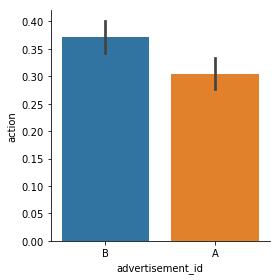

In [2]:
data_path = 'data/advertisement_clicks.csv'
df2 = pd.read_csv(data_path)
seaborn.factorplot(x='advertisement_id',y='action',data=df2,kind='bar')

#### Two sample t-test
Assuming 1. the sample are gaussian distribution (or bernouli? in ctr case) 2. sample sizes are equal 3. same variance. We have
$$ t = \frac{\bar{X_1}-\bar{X_2}}{S_p\sqrt{2/N}} $$
where $S_p$ is pooled standard deviation.
$$ S_p = \sqrt{\frac{s^2_{X_1}+s^2_{X_2}}{2}} $$
Note that its not always true for these assumptions. For example, for unequal sample size we have
$$ t = \frac{\bar{X_1}-\bar{X_2}}{S_p\sqrt{1/n_1+1/n_2}} $$ 
where
$$ S_p = \sqrt{\frac{(n_1-1)s^2_{X_1}+(n_2-1)s^2_{X_2}}{n_1+n_2-2}} $$
For unequal sample sizes, unequal variances, we have Welch's t-test. (in scipy.stats.ttest_ind(equal_var=False)

Further more, for non-gaussion distribution, we might try Kolmogorov-Smirnov(scipy.stats.kstest), Kruskal-Wallis(scipy.stats.kruskal) or Mann-Whitney U test (scipy.stats.mannwhitneyu)

First we run T-test and then find the probability of exist such difference for null hypothesis (in this case, null hypothesis means that ctr are equal), namely p-value. 
> Wiki P-value - The probability for a given statistical model that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two compared groups) would be the same as or of greater magnitude than the actual observed results

If p-value is smaller than confidence threshold $\alpha$, we reject the null hypothesis and say that they are truely different. 

In [3]:
ad_A = df2.loc[df2.advertisement_id=='A','action'].values
ad_B = df2.loc[df2.advertisement_id=='B','action'].values

In [4]:
t, p = ss.ttest_ind(ad_A, ad_B)
print("t:\t", t, "p2:\t", p)

t:	 -3.2211732138 p2:	 0.00129719054671


Note that in scipy.stats.ttest_ind implement "two-side" test, means that our hypothesis has assumptions "mean(A) gt mean(B) or mean(A) lt mean(B)" In the other hand, one side means we only test that "mean(A) gt mean(B)".
Therefore, in this case, if our confidence threshold is 5%, than we can say that at confidence level 95% we observed the difference mean of two distributions are true.

#### chi2 test
Alternatively, we can test chi2

In [5]:
A_clk = ad_A.sum()
A_noclk = ad_A.size - ad_A.sum()
B_clk = ad_B.sum()
B_noclk = ad_B.size - ad_B.sum()
T = np.array([[A_clk, A_noclk], [B_clk, B_noclk]])

In [6]:
def get_p_value(T):
    det = T[0,0]*T[1,1] - T[0,1]*T[1,0]
    c2 = float(det) / T[0].sum() * det / T[1].sum() * T.sum() / T[:,0].sum() / T[:,1].sum()
    p = 1 - ss.chi2.cdf(x=c2, df=1)
    return p
print(get_p_value(T))

0.00130695027321


In [7]:
ss.chi2_contingency(T, correction=False)

(10.332683816299898, 0.0013069502732125406, 1, array([[ 338.,  662.],
        [ 338.,  662.]]))